In [1]:
import sys
sys.path.append('../..')
from utils.workflow import WorkflowModel
from utils.data import RK4DataGenerator, stack_real_values, sin_beta_szero, first_below_threshold
import utils.plotting as plotting
from utils.eval import eval_predictions, format_latex_table
import numpy as np

2026-02-17 17:54:03.219580: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-17 17:54:03.254822: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-17 17:54:04.315205: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


E0000 00:00:1771361645.510673  484973 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1771361645.518257  484973 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
t_0, t_f, N = 0, 50, 100
nop_data = 50
S0, I0, R0 = 99, 1, 0
noise_std = N * 0.00
gamma = 0.07
test_t = np.linspace(t_0, t_f, nop_data)
rkdata = RK4DataGenerator(sin_beta_szero,
    gamma=gamma,
    t_0=t_0, 
    t_f=t_f, 
    N=N, 
    S0=S0, I0=I0, R0=R0
)
sir_real = rkdata.generate(test_t)
sir_data = rkdata.generate(test_t, noise_std)

In [3]:
sir_data[:,0]

array([99.        , 98.37992736, 97.24253061, 95.16328302, 91.56394681,
       85.97787604, 78.52912135, 70.25665498, 62.48407252, 55.88527875,
       50.45950631, 45.62905135, 40.6894681 , 35.19375867, 29.09133995,
       22.73063125, 16.81072286, 11.93666666,  8.36204162,  5.98237482,
        4.44465525,  3.4800053 ,  2.85983701,  2.44742196,  2.18163121,
        1.97778999,  1.79218739,  1.60387256,  1.40868888,  1.21457538,
        1.03415566,  0.87693767,  0.74784955,  0.64727314,  0.57221354,
        0.51790789,  0.47956842,  0.45275963,  0.43339833,  0.41775357,
        0.40244671,  0.38504085,  0.36582041,  0.34571353,  0.32559302,
        0.30627628,  0.28852534,  0.27304689,  0.26049167,  0.25096113])

In [4]:
szero_value, szero_point = first_below_threshold(sir_data[:,0], threshold=1) 

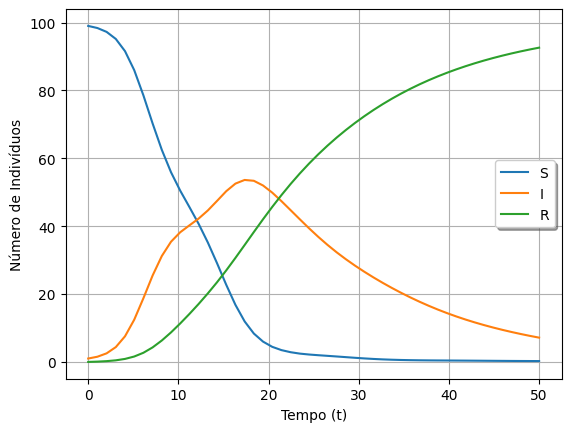

In [5]:
plotting.plot_rk_curves(test_t, sir_real)

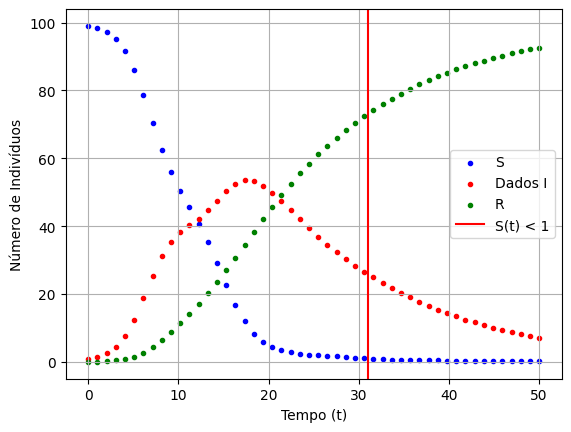

In [6]:
plotting.plot_rk_data(test_t, sir_data, 
    vlines=[(szero_point, "S(t) < 1", "red")],
    figname="rk-data-szero")

In [7]:
model = WorkflowModel(t_0, t_f, sir_data[:,1], test_t,
    N=N,
    gamma=gamma,
    beta_estimation_window=10,
    hidden_layer_size=60,
    n_hidden_layers=4,
    w_physics=1000,
    scaling="min/max",
    activation="tanh",
    adam_iterations=500000,
    # parallel_pinns=True,
    estimate_beta=True,
    early_stopping=True,
    # adaptative_wdata=True,
    beta_hard_constraints=False,
    fine_tunning_using_lbfgs=False)
model.S0, model.I0, model.beta0

Compiling model...
'compile' took 0.005049 s



(np.float64(1.8815267948426349),
 np.float64(0.0),
 np.float64(0.4919812244571398))

In [8]:
model.train()

Epoch 428600: early stopping


(<deepxde.model.LossHistory at 0x7f0d72b655d0>,
 <deepxde.model.TrainState at 0x7f0d72b40cd0>)

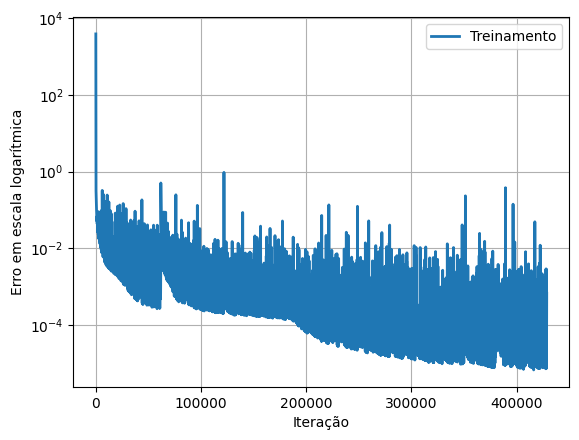

In [9]:
plotting.plot_losshistory(model.losshistory, "loss-szero")

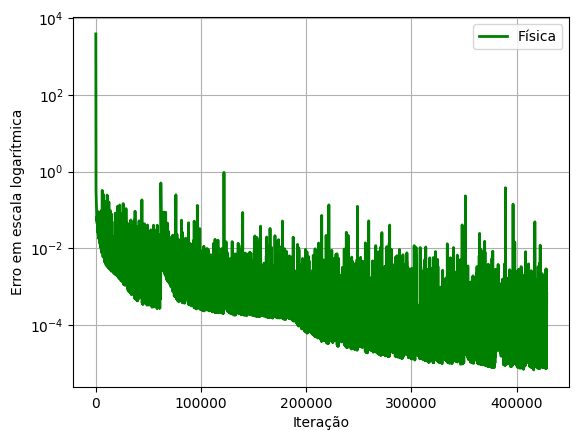

In [10]:
plotting.plot_phys_losshistory(model.losshistory, model.n_physics, "loss-physics-szero")

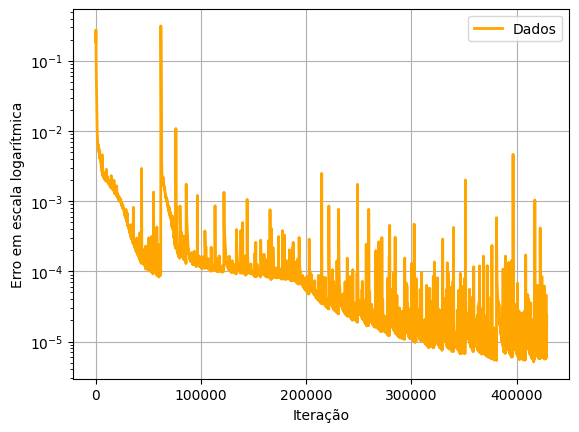

In [11]:
plotting.plot_data_losshistory(model.losshistory, "loss-data-szero")

In [12]:
predictions = model.predict(test_t)

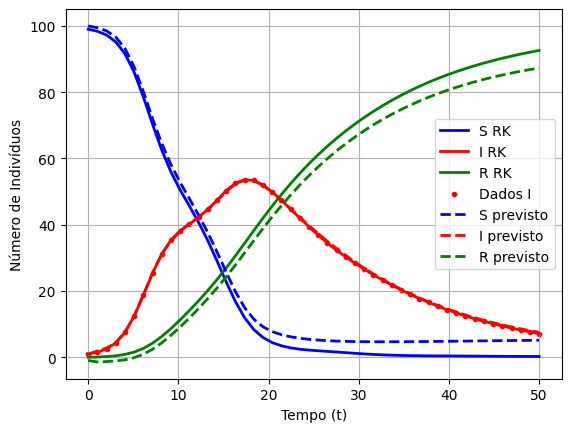

In [13]:
plotting.plot_results(sir_real, sir_data, predictions, test_t, N=N,
    figname="predicted-szero")

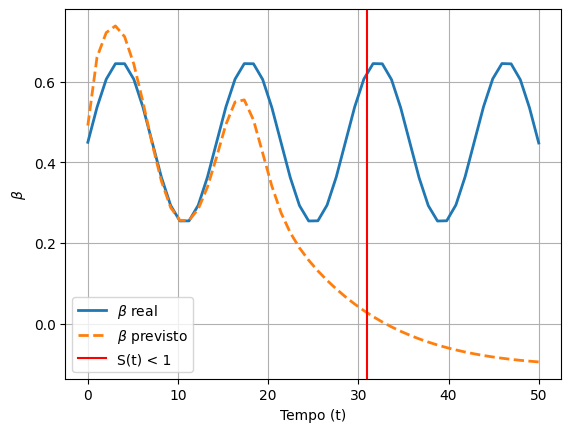

In [14]:
real_beta = sin_beta_szero(test_t)
plotting.plot_beta_comparison(real_beta, predictions[:,2], test_t,
    vlines=[(szero_point, "S(t) < 1", "red")],
    figname="predicted-beta-szero" 
)

In [15]:
if model.data_weight_hist:
    plotting.plot_wdata(model.data_weight_hist)

In [16]:
real_values = stack_real_values(sir_real, real_beta)
metrics = eval_predictions(real_values, predictions)

In [17]:
metrics

,compartiment,RMSE,L2,L-infinity
0,S,3.472823,0.086079,4.896120
1,I,0.254809,0.008325,0.495861
2,beta,0.372750,0.764315,0.733027


In [18]:
format_latex_table(metrics)

'\\begin{tabular}{llrrr}\n\\toprule\n & compartiment & RMSE & L2 & L-infinity \\\\\n\\midrule\n0 & S & 3.472823 & 0.086079 & 4.896120 \\\\\n1 & I & 0.254809 & 0.008325 & 0.495861 \\\\\n2 & beta & 0.372750 & 0.764315 & 0.733027 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [19]:
model.formated_total_training_time

'00:11:34'